# Watermark Detection


## 1. Setup

In [1]:
import os
import matplotlib.pyplot as plt

import torch
try:
    import torch_xla.core.xla_model as xm
except ImportError:
    xm = None

import numpy as np

%load_ext autoreload
%autoreload 2

os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = xm.xla_device()

print('Current device:', device)

Current device: mps


## 2. Visualize Data

In [3]:
from project.data.data_module import DataModule

hparams = {
    'learning_rate': 1e-05,
    'batch_size': 32,
    'batch_norm': False,
    'epochs': 5,
    'num_classes': 2,
    'num_workers': 8,
    'device': device,
    'load_method': 'memory',
}

data_module = DataModule(hparams)
data_module.prepare_data()

In [4]:
dataiter = iter(data_module.get_loader('train'))
for images, labels in dataiter:
    break

In [5]:
idx_to_class = data_module.get_idx_to_class_dict()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.298356e-07..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.298356e-07..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.298356e-07..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7952925e-07..1.0000002].


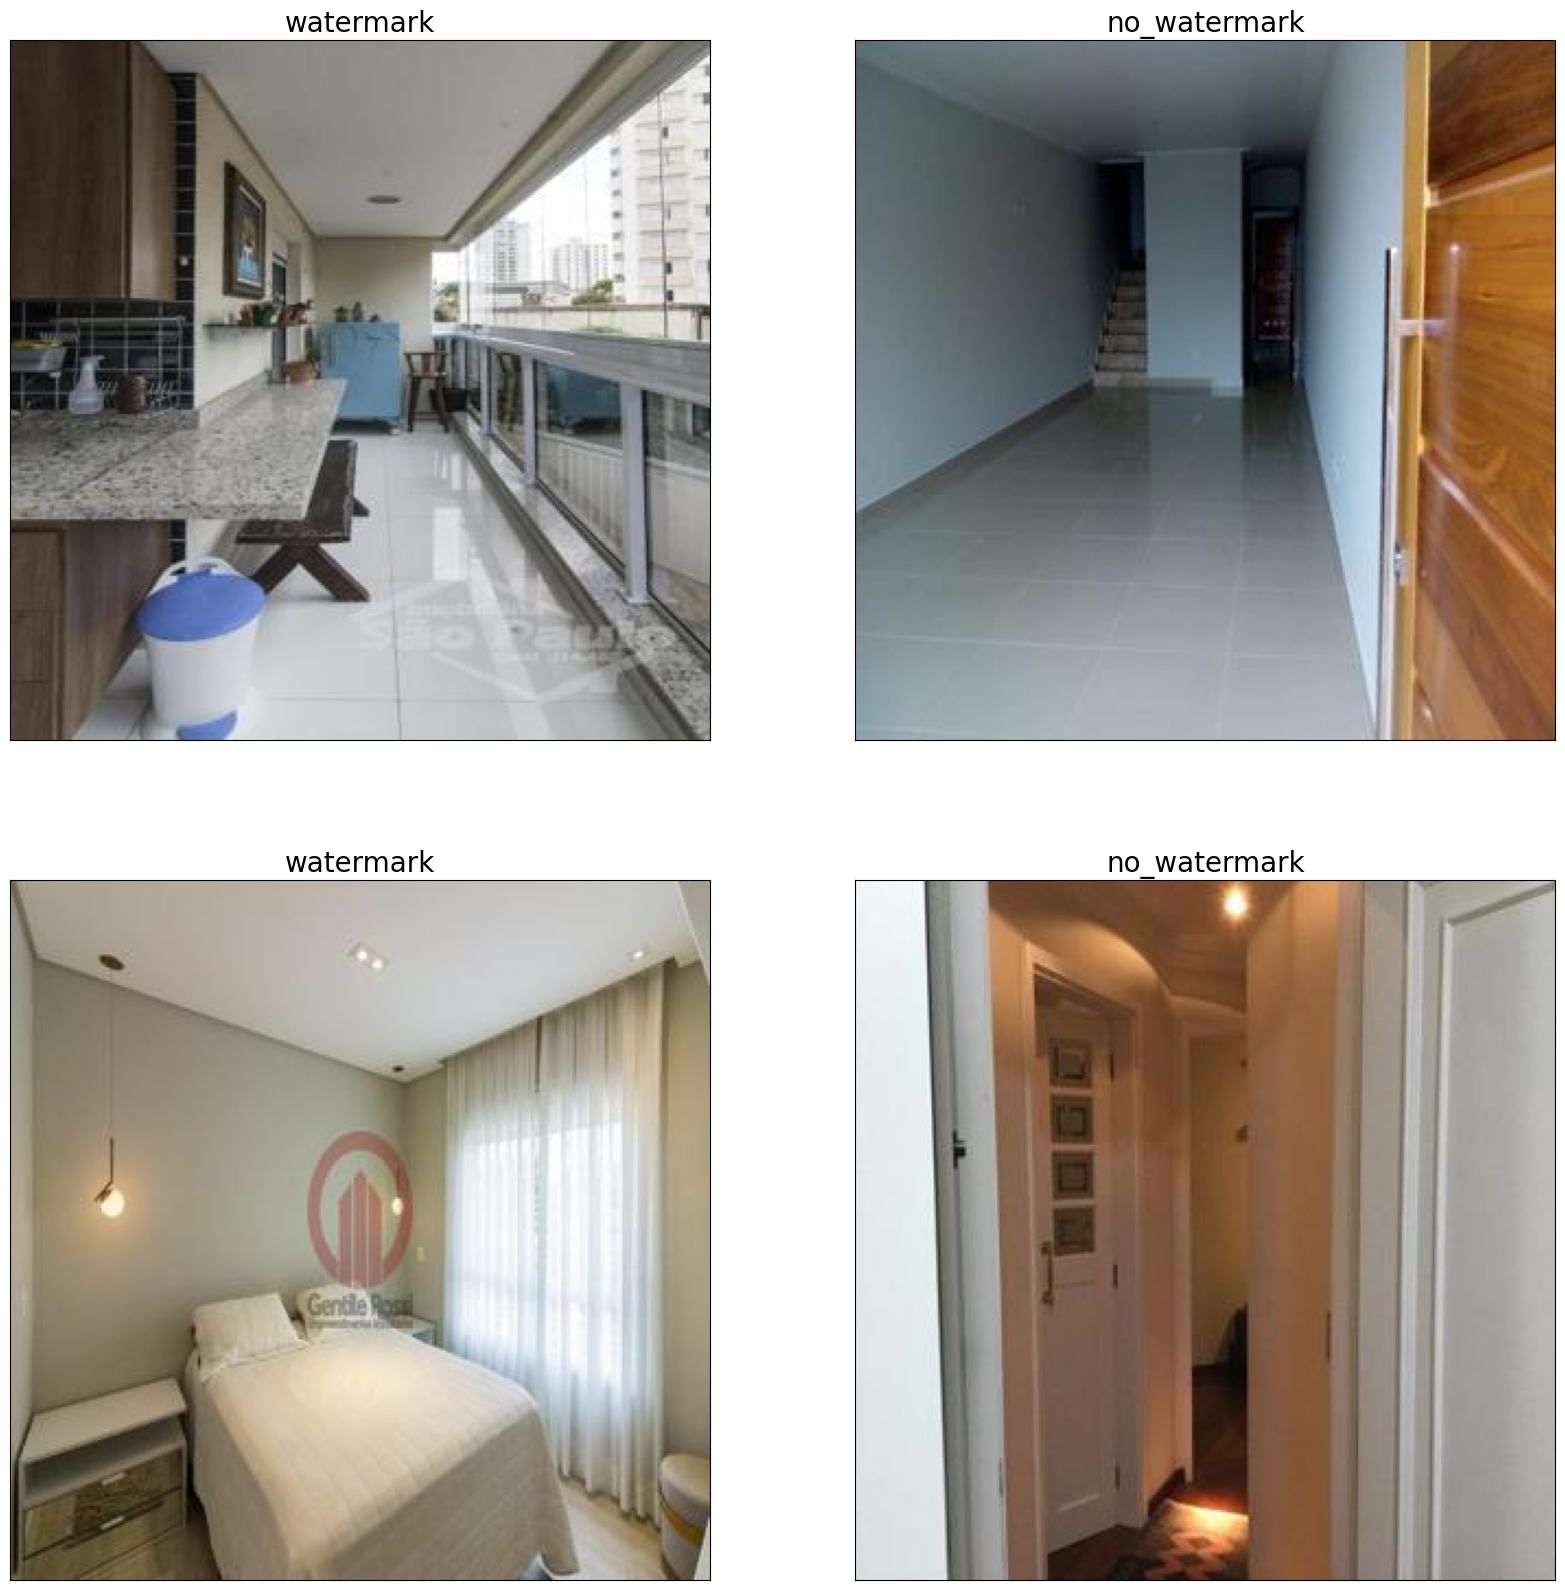

In [6]:
from project.utils.images import imshow

fig = plt.figure(figsize=(20,20))

for idx in range(4):
    ax = fig.add_subplot(2, 2, idx+1, xticks=[], yticks=[])
    imshow(images[idx], ax)
    ax.set_title(idx_to_class[int(labels[idx])], fontdict={'fontsize': 20})

## 3. Baseline Model

In [16]:
from project.networks.naive import SimpleCNN
from project.utils.models import init_weights, number_of_parameters

model = SimpleCNN().to(device)
model.apply(init_weights)

print('# Parameters: ', number_of_parameters(model))

# Parameters:  10694850


In [17]:
model(images[0].unsqueeze(0).to(device)).shape

torch.Size([1, 2])

In [54]:
from project.networks.naive import NaiveModel
from project.utils.models import init_weights, number_of_parameters

model = NaiveModel(hparams=hparams).to(device)
model.apply(init_weights)

print('# Parameters: ', number_of_parameters(model))

# Parameters:  23673217


In [19]:
from project.train.train_model import train_model
import torch.nn as nn

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 3.1 Test Implementation

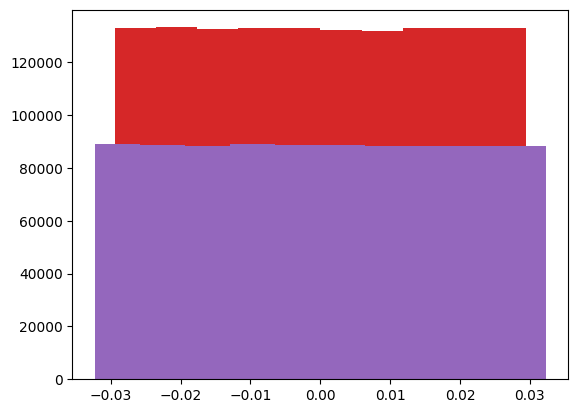

In [48]:
for l in model.layer1.children():
    if isinstance(l, nn.Conv2d):
        plt.hist(l.weight.data.flatten().detach().cpu().numpy())

for l in model.layer2.children():
    if isinstance(l, nn.Conv2d):
        plt.hist(l.weight.data.flatten().detach().cpu().numpy())

for l in model.layer3.children():
    if isinstance(l, nn.Conv2d):
        plt.hist(l.weight.data.flatten().detach().cpu().numpy())

for l in model.layer4.children():
    if isinstance(l, nn.Conv2d):
        plt.hist(l.weight.data.flatten().detach().cpu().numpy())

for l in model.layer5.children():
    if isinstance(l, nn.Conv2d):
        plt.hist(l.weight.data.flatten().detach().cpu().numpy())

In [20]:
from tqdm.autonotebook import tqdm

sample_image, sample_target = images[0].unsqueeze(0).to(device), labels[0].unsqueeze(0).to(device)

model = SimpleCNN().to(device)
model.apply(init_weights)

iterations = 100

test_loop = tqdm(range(iterations),total=iterations, desc='Test Implementation [single image]')

for iter in test_loop:
    model.train()
    optimizer.zero_grad() 

    pred = model(sample_image)

    loss = loss_func(pred, sample_target.float())
    loss.backward()
    
    optimizer.step()

    test_loop.set_postfix(curr_loss = "{:.8f}".format(loss.item()))

Test Implementation [single image]: 100%|██████████| 100/100 [00:01<00:00, 83.52it/s, curr_loss=0.68527859]


In [50]:
from tqdm.autonotebook import tqdm

sample_images, sample_targets = images[:10].to(device), labels[:10].to(device)

model = SimpleCNN().to(device)
model.apply(init_weights)

iterations = 100

test_loop = tqdm(range(iterations),total=iterations, desc='Test Implementation [10 images]')

for iter in test_loop:
    model.train()
    optimizer.zero_grad() 

    pred = model(sample_images)

    loss = loss_func(pred, sample_targets.unsqueeze(1).float())

    loss.backward()
    optimizer.step()

    test_loop.set_postfix(curr_loss = "{:.8f}".format(loss.item()))

Test Implementation [10 images]: 100%|██████████| 100/100 [00:04<00:00, 22.08it/s, curr_loss=0.69375050]


### 3.2 Test EfficientNet V2 Small

In [12]:
import torchvision

model = torchvision.models.efficientnet_v2_s(weights='DEFAULT')
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [13]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1),
    nn.Sigmoid()
)

In [14]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
for param in model.features:
    param.requires_grad = False

### 4. Train Model

In [51]:
from torch.utils.tensorboard import SummaryWriter
from project.logger.settings import LOGS_ROOT

logs_path = os.path.join(LOGS_ROOT, model._get_name())

num_of_runs = len(os.listdir(logs_path)) if os.path.exists(logs_path) else 0

logs_path = os.path.join(logs_path, f'run_{num_of_runs + 1}')
logger = SummaryWriter(logs_path)

In [52]:
model = SimpleCNN().to(device)
model.apply(init_weights)

hparams['learning_rate'] = 0.001
hparams['epochs'] = 50

train_model(model, data_module, loss_func, optimizer, hparams, logger=logger)

Training Epoch [1/50]: 100%|█| 206/206 [01:04<00:00,  3.17it/s, curr_train_loss=0.69302078, lr=0.001
Validation Epoch [1/50]: 100%|███████████████| 69/69 [00:09<00:00,  7.02it/s, valid_loss=0.69315640]
Training Epoch [2/50]: 100%|█| 206/206 [01:05<00:00,  3.17it/s, curr_train_loss=0.69309244, lr=0.001
Validation Epoch [2/50]: 100%|███████████████| 69/69 [00:08<00:00,  8.61it/s, valid_loss=0.69315640]
Training Epoch [3/50]: 100%|█| 206/206 [01:07<00:00,  3.06it/s, curr_train_loss=0.69310558, lr=0.001
Validation Epoch [3/50]: 100%|███████████████| 69/69 [00:08<00:00,  8.25it/s, valid_loss=0.69315640]
Training Epoch [4/50]: 100%|█| 206/206 [01:06<00:00,  3.11it/s, curr_train_loss=0.69324592, lr=0.001
Validation Epoch [4/50]: 100%|███████████████| 69/69 [00:11<00:00,  6.04it/s, valid_loss=0.69315640]
Training Epoch [5/50]: 100%|█| 206/206 [01:11<00:00,  2.89it/s, curr_train_loss=0.69302510, lr=0.001
Validation Epoch [5/50]: 100%|███████████████| 69/69 [00:10<00:00,  6.59it/s, valid_loss=0.

KeyboardInterrupt: 

In [21]:
train_dataloader = data_module.get_loader('train')
test_dataloader = data_module.get_loader('test')

print(f"Training Acc: {model.get_accuracy(train_dataloader)[1] * 100}%")
print(f"Validation Acc: {model.get_accuracy(test_dataloader)[1] * 100}%")

AttributeError: 'NaiveModel' object has no attribute 'model'